In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # no partial fit
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report


from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_27476/1144886652.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)
(1106587, 23)


In [4]:
# Calculate y based on 'product' column
cfpb_df['debt_collection'] = (cfpb_df['Product'] == 'Debt collection').astype(int)

In [5]:
# split dataset train, dev, test
train_df, dev_df, test_df = np.split(cfpb_df[['Consumer complaint narrative','debt_collection']].sample(len(cfpb_df), random_state = 42), 
                                     [int(len(cfpb_df)*0.75), int(len(cfpb_df)*0.9)])

In [6]:
# Load the trained vectorizer
with open('tfidf_vectorizer_999.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

16678

In [7]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 4min 55s


In [8]:
%%time
# Select top 10000 features, 5000 runs faster without significant loss (almost the same)
selector = SelectKBest(chi2, k=5000)
X_train = selector.fit_transform(X_train, y_train)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 460 ms


In [9]:
%%time
# some balancing
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Wall time: 12min 25s


In [10]:
from sklearn.utils import shuffle
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

### Logistic Regression

In [11]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

clf = LogisticRegression(random_state=42, solver='saga', warm_start=True, n_jobs=-1)

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    clf.fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [17:21<00:00, 38.58s/it]


In [12]:
# Define batch size and number of batches
batch_size = 10000
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:53<00:00,  2.56it/s]


Train
accuracy_score 0.8481360170204055
balanced_accuracy_score 0.8481360170204055
average_precision_score 0.796767141347184
              precision    recall  f1-score   support

           0       0.84      0.85      0.85    683885
           1       0.85      0.84      0.85    683885

    accuracy                           0.85   1367770
   macro avg       0.85      0.85      0.85   1367770
weighted avg       0.85      0.85      0.85   1367770



Dev
accuracy_score 0.847308239149818
balanced_accuracy_score 0.8338382149626392
average_precision_score 0.4761882970968564
              precision    recall  f1-score   support

           0       0.96      0.85      0.90    136701
           1       0.55      0.81      0.65     29287

    accuracy                           0.85    165988
   macro avg       0.75      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 122308), (1, 43680)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.87 s


<AxesSubplot:ylabel='Frequency'>

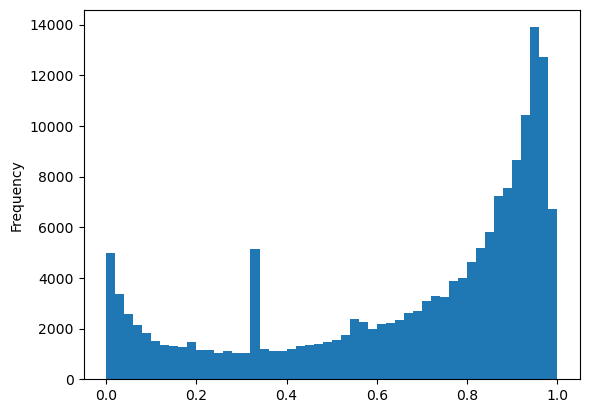

In [13]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

In [14]:
# smaller batch size

In [15]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

clf = LogisticRegression(random_state=42, solver='saga', warm_start=True, n_jobs=-1)

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    clf.fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [13:58<00:00,  3.26it/s]


In [16]:
# Define batch size and number of batches
batch_size = 10000
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:52<00:00,  2.61it/s]


Train
accuracy_score 0.7972758577831068
balanced_accuracy_score 0.7972758577831068
average_precision_score 0.7307088239864001
              precision    recall  f1-score   support

           0       0.82      0.76      0.79    683885
           1       0.78      0.84      0.80    683885

    accuracy                           0.80   1367770
   macro avg       0.80      0.80      0.80   1367770
weighted avg       0.80      0.80      0.80   1367770



Dev
accuracy_score 0.7673265537267754
balanced_accuracy_score 0.7843540606654251
average_precision_score 0.37215171423230586
              precision    recall  f1-score   support

           0       0.95      0.76      0.84    136701
           1       0.42      0.81      0.55     29287

    accuracy                           0.77    165988
   macro avg       0.68      0.78      0.70    165988
weighted avg       0.86      0.77      0.79    165988

Prediction [(0, 109170), (1, 56818)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.27 s


<AxesSubplot:ylabel='Frequency'>

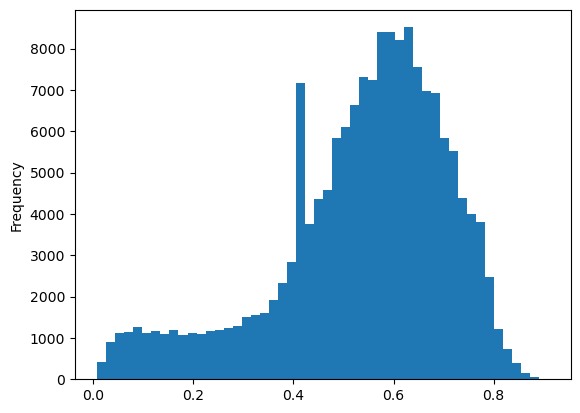

In [17]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### The other approach

In [18]:
# Initialize a LogisticRegression model, ‘log_loss’ gives logistic regression, a probabilistic classifier.
clf= SGDClassifier(loss='log_loss',random_state=42, alpha=1e-4, n_iter_no_change=3, early_stopping=False)

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        clf.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        clf.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:33<00:00,  1.25s/it]


In [19]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 10000
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:52<00:00,  2.61it/s]


Train
accuracy_score 0.8447977364615396
balanced_accuracy_score 0.8447977364615396
average_precision_score 0.7962053982140863
              precision    recall  f1-score   support

           0       0.83      0.86      0.85    683885
           1       0.86      0.82      0.84    683885

    accuracy                           0.84   1367770
   macro avg       0.85      0.84      0.84   1367770
weighted avg       0.85      0.84      0.84   1367770



Dev
accuracy_score 0.8528688820878618
balanced_accuracy_score 0.8311104605304835
average_precision_score 0.48083162438830734
              precision    recall  f1-score   support

           0       0.95      0.86      0.91    136701
           1       0.56      0.80      0.66     29287

    accuracy                           0.85    165988
   macro avg       0.76      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 124141), (1, 41847)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.28 s


<AxesSubplot:ylabel='Frequency'>

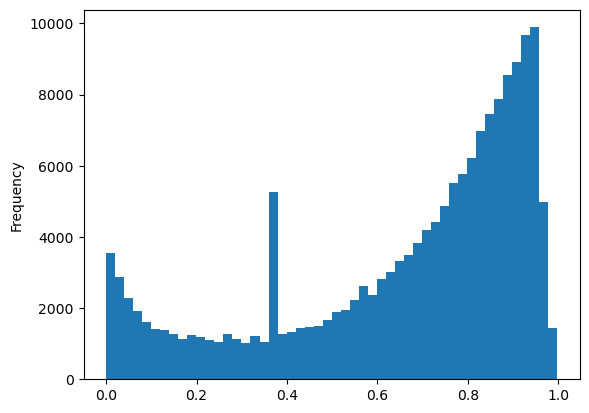

In [20]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Define batch size and number of batches
# batch_size = 100
# n_batches = X_dev.shape[0] // batch_size

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_dev[start:end]

#     # Predict on the batch and append to list
#     batch_pred = clf.predict(batch_X.A)
#     batch_pred_proba = clf.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

smaller batch size

In [21]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# Initialize a LogisticRegression model, ‘log_loss’ gives logistic regression, a probabilistic classifier.
clf= SGDClassifier(loss='log_loss',random_state=42, alpha=1e-4, n_iter_no_change=3, early_stopping=False)

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        clf.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        clf.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [00:34<00:00, 78.39it/s]


In [22]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 10000
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:51<00:00,  2.62it/s]


Train
accuracy_score 0.8434473632262734
balanced_accuracy_score 0.8434473632262734
average_precision_score 0.7959078193861251
              precision    recall  f1-score   support

           0       0.83      0.87      0.85    683885
           1       0.86      0.82      0.84    683885

    accuracy                           0.84   1367770
   macro avg       0.84      0.84      0.84   1367770
weighted avg       0.84      0.84      0.84   1367770



Dev
accuracy_score 0.854977468250717
balanced_accuracy_score 0.830177184156725
average_precision_score 0.4828076963148395
              precision    recall  f1-score   support

           0       0.95      0.87      0.91    136701
           1       0.56      0.79      0.66     29287

    accuracy                           0.85    165988
   macro avg       0.76      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 124821), (1, 41167)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.3 s


<AxesSubplot:ylabel='Frequency'>

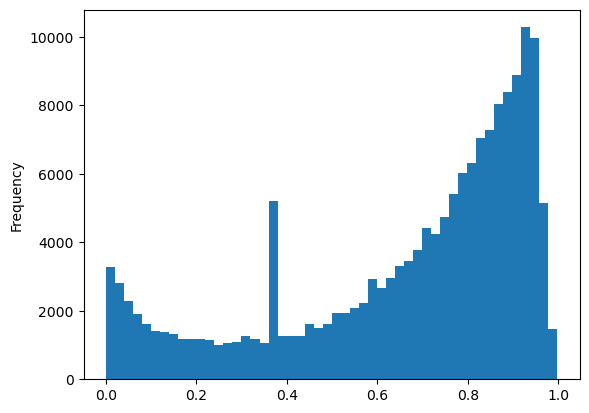

In [23]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Define batch size and number of batches
# batch_size = 100
# n_batches = X_dev.shape[0] // batch_size

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_dev[start:end]

#     # Predict on the batch and append to list
#     batch_pred = clf.predict(batch_X.A)
#     batch_pred_proba = clf.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)